<a href="https://colab.research.google.com/github/Nancy-Shi/Individual_Infection_Network/blob/main/1206_star_tree_etc_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compare star, circle, tree, square lattice networks**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import numpy as np
import pandas as pd
import os
import sympy as sp
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
import math

In [ ]:
def generate_star_network(N, center=0):
    if N < 2:
        return [[0]*N for _ in range(N)]
    if center < 0 or center >= N:
        raise ValueError("center must be in [0, N-1]")

    adj_matrix = [[0]*N for _ in range(N)]
    for j in range(N):
        if j != center:
            adj_matrix[center][j] = 1
            adj_matrix[j][center] = 1
    return adj_matrix

In [ ]:
def generate_circle_network(N):
    adj_matrix = [[0]*N for _ in range(N)]
    if N < 2:
        return adj_matrix
    for i in range(N):
        j = (i + 1) % N
        adj_matrix[i][j] = 1
        adj_matrix[j][i] = 1
    return adj_matrix

In [ ]:
def generate_rect_lattice(N, W, L):
# W * L is the rectangular grid size, N can be smaller than W * L if the grid is not completely filled.
    adj = [[0]*N for _ in range(N)]
    for i in range(N):
        r = i // W
        c = i % W
        if c+1 < W:
            j = i + 1
            if j < N:
                adj[i][j] = 1
                adj[j][i] = 1
        if r+1 < L:
            j = i + W
            if j < N:
                adj[i][j] = 1
                adj[j][i] = 1
    return adj

In [ ]:
def generate_kary_tree(N, k):
  #k = 2 for binary tree, 3 for ternary tree
    if N <= 0:
        return []
    if N == 1:
        return [[0]]
    if k < 1:
        raise ValueError("k must be at least 1")
    adj = [[0]*N for _ in range(N)]
    for i in range(N):
        for c in range(1, k+1):
            child = k*i + c
            if child < N:
                adj[i][child] = 1
                adj[child][i] = 1
    return adj

In [ ]:
# Function to generate a network from an N by N adjacency matrix.
def generate_network(adj_matrix):
    G = nx.Graph()
    N = len(adj_matrix)
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)
    return G

In [ ]:
def preprocess_neighbors(G):
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    neighbors_idx = []

    for v in nodes:
        neighs = list(G.neighbors(v))
        neighbors_idx.append(np.array([node_index[u] for u in neighs], dtype=int))

    return nodes, node_index, neighbors_idx

In [ ]:
def fixed_point_solver_message_passing(neighbors_idx, seed_index, p_val, tol=1e-6, max_iter=5000, relax=0.3):

    n = len(neighbors_idx)

    edge_to_idx = {}
    idx_to_edge = []

    for i in range(n):
        for j in neighbors_idx[i]:
            edge_to_idx[(j, i)] = len(idx_to_edge)
            idx_to_edge.append((j, i))

    m = len(idx_to_edge)

    # Messages theta_{j->i}: probability that j does NOT infect i
    theta = np.ones(m, dtype=float)

    for _ in range(max_iter):
        theta_new = theta.copy()

        for e_idx, (j, i) in enumerate(idx_to_edge):
            if j == seed_index:
                theta_new[e_idx] = 1.0 - p_val
                continue

            neigh_j = neighbors_idx[j]

            # Compute u_{j->i} = product over k in N(j)\{i} of theta_{k->j}
            if len(neigh_j) == 0:
                u = 1.0
            else:
                prod = 1.0
                for k in neigh_j:
                    if k == i:
                        continue
                    prod *= theta[edge_to_idx[(k, j)]]
                u = prod

            theta_new[e_idx] = 1.0 - p_val + p_val * u

        theta_updated = (1.0 - relax) * theta + relax * theta_new

        if np.max(np.abs(theta_updated - theta)) < tol:
            theta = theta_updated
            break

        theta = theta_updated

    sigma = np.zeros(n, dtype=float)

    for i in range(n):
        if i == seed_index:
            sigma[i] = 1.0
            continue

        neigh_i = neighbors_idx[i]
        if len(neigh_i) == 0:
            sigma[i] = 0.0
            continue

        prod = 1.0
        for j in neigh_i:
            prod *= theta[edge_to_idx[(j, i)]]
        sigma[i] = 1.0 - prod

    return sigma

In [ ]:
from joblib import Parallel, delayed

def compute_attack_matrix(G, p_val, n_jobs=-1):
    nodes, node_index, neighbors_idx = preprocess_neighbors(G)
    n = len(nodes)

    sigmas = Parallel(n_jobs=n_jobs)(
        delayed(fixed_point_solver_message_passing)(neighbors_idx, seed_index=node_index[s], p_val=p_val)
        for s in nodes
    )

    mat = np.array(sigmas).T

    return nodes, mat



def save_attack_csv(nodes, mat, p_val, label, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame(
        mat,
        index=[f"sigma_{i}" for i in nodes],
        columns=[f"Seed {i}" for i in nodes]
    )
    path = os.path.join(outdir, f"individual_attack_{label}.csv")
    df.to_csv(path, float_format="%.6f")
    return path, df

In [ ]:
# Function to compute the average infection rate by taking the average of the matrix for each row, excluding the 1 value (seed node case)
def compute_average_attack(nodes, mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)
    return np.nanmean(mat_no_diag, axis=1)

def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)

    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })

    path = os.path.join(outdir, f"average.csv")
    df.to_csv(path, index=False, float_format="%.6f")

    return path, df


In [ ]:
# Function to visualize the network based on the node index, color the nodes based on a heatmap scale using their average attack rate
def visualize_attack_network_comparison(
    G_star,   nodes_star,   avg_star,
    G_circle, nodes_circle, avg_circle,
    G_tree,   nodes_tree,   avg_tree,
    G_sq,     nodes_sq,     avg_sq,
    cmap_name="jet",
    out_path=None
):
    avg_star   = np.asarray(avg_star, dtype=float)
    avg_circle = np.asarray(avg_circle, dtype=float)
    avg_tree   = np.asarray(avg_tree, dtype=float)
    avg_sq     = np.asarray(avg_sq, dtype=float)

    all_vals = np.concatenate([avg_star, avg_circle, avg_tree, avg_sq])
    vmin = float(np.nanmin(all_vals))
    vmax = float(np.nanmax(all_vals))

    fig, axes = plt.subplots(2, 2, figsize=(24, 16))

    def draw_panel(ax, G, nodes, avg_attack, panel_label, vmin, vmax, layout="spring"):
        nodes = list(nodes)
        avg_attack = np.asarray(avg_attack, dtype=float)
        attack_dict = {node: avg_attack[i] for i, node in enumerate(nodes)}

        if layout == "circle":
            pos = nx.circular_layout(G)
        else:
            pos = nx.spring_layout(G, seed=42, k=0.25, iterations=300)

        node_colors = [attack_dict[n] for n in G.nodes()]

        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.8, width=0.8, edge_color="gray")
        nodes_draw = nx.draw_networkx_nodes(
            G, pos, ax=ax,
            node_color=node_colors,
            cmap=plt.get_cmap(cmap_name),
            node_size=30,
            linewidths=0.3,
            edgecolors="grey",
            vmin=vmin, vmax=vmax
        )

        ax.set_axis_off()
        ax.text(
            0.03, 0.97, panel_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=20, fontweight="bold"
        )
        return nodes_draw

    nodes_draw = draw_panel(
        axes[0, 0], G_star, nodes_star, avg_star,
        panel_label="A (Star)", vmin=vmin, vmax=vmax, layout="spring"
    )
    draw_panel(
        axes[0, 1], G_circle, nodes_circle, avg_circle,
        panel_label="B (Circle)", vmin=vmin, vmax=vmax, layout="circle"
    )
    draw_panel(
        axes[1, 0], G_tree, nodes_tree, avg_tree,
        panel_label="C (Tree)", vmin=vmin, vmax=vmax, layout="spring"
    )
    draw_panel(
        axes[1, 1], G_sq, nodes_sq, avg_sq,
        panel_label="D (Square lattice)", vmin=vmin, vmax=vmax, layout="spring"
    )

    fig.tight_layout(rect=[0.03, 0.10, 0.97, 1.0])

    cbar_ax = fig.add_axes([0.20, 0.04, 0.60, 0.02])
    cbar = fig.colorbar(nodes_draw, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Average individual infection probability", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    if out_path is not None:
        plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    plt.show()

In [ ]:
def save_graph_neighbor_csv(G, filename, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)

    nodes = sorted(G.nodes())
    index_map = {v: i for i, v in enumerate(nodes)}

    data = []
    for v in nodes:
        neigh_indices = [index_map[u] for u in G.neighbors(v)]
        neigh_str = ",".join(str(n) for n in neigh_indices)
        degree = len(neigh_indices)
        data.append([index_map[v], neigh_str, degree])

    df = pd.DataFrame(data, columns=["node", "neighbors", "degree"])
    df.to_csv(path, index=False)

    return path, df

In [ ]:
import pandas as pd
import os

def rank_nodes_by_attack(csv_path, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    df = pd.read_csv(csv_path)

    df_ranked = df.sort_values(by="AverageAttackRate", ascending=False).reset_index(drop=True)

    df_ranked["Rank"] = df_ranked.index + 1

    os.makedirs(outdir, exist_ok=True)
    out_path = os.path.join(outdir, "ranked_graphs_" + os.path.basename(csv_path))
    df_ranked.to_csv(out_path, index=False, float_format="%.6f")

    print("\nRanked results:\n")
    print(df_ranked.head())

    return out_path, df_ranked

In [ ]:
def plot_ranked_histogram_four_panel(
    ranked_csv_path_star,
    ranked_csv_path_circle,
    ranked_csv_path_tree,
    ranked_csv_path_sq,
    outdir,
    fig_name
):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    def build_hist(ax, ranked_csv, panel_label):
        df = pd.read_csv(ranked_csv)
        vals = df["AverageAttackRate"].values
        vals = vals[~np.isnan(vals)]

        plt.style.use("seaborn-v0_8-white")

        main_bins = np.arange(0, 0.1, 0.01)
        hist_bins = np.arange(0, 0.1 + 0.001, 0.005)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(main_bins)-1))

        for i in range(len(main_bins)-1):
            lo, hi = main_bins[i], main_bins[i+1]
            mask = (vals >= lo) & (vals < hi)

            ax.hist(
                vals[mask],
                bins=hist_bins,
                alpha=0.85,
                color=colors[i],
                edgecolor="white",
                linewidth=0.4
            )

        ax.set_xlabel("Individual Infection Probability", fontsize=10)
        ax.set_ylabel("Density", fontsize=10)

        ax.text(
            0.03, 0.97, panel_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=10, fontweight="bold"
        )

        ax.tick_params(labelsize=8)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(1.2)
        ax.spines["bottom"].set_linewidth(1.2)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300)

    build_hist(axes[0, 0], ranked_csv_path_star,   panel_label="A (Star)")
    build_hist(axes[0, 1], ranked_csv_path_circle, panel_label="B (Circle)")
    build_hist(axes[1, 0], ranked_csv_path_tree,   panel_label="C (Tree)")
    build_hist(axes[1, 1], ranked_csv_path_sq,     panel_label="D (Square lattice)")

    plt.tight_layout()

    fig_path = os.path.join(outdir, fig_name)
    plt.savefig(fig_path, bbox_inches="tight", dpi=300)
    plt.show()


In [ ]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def plot_saturating(ax, x_raw, y, xlabel, panel_label, color):
    x_scaled = x_raw.values * 1e3
    x = x_scaled
    p0 = [1.0, 1.0, np.median(x)]
    params, _ = curve_fit(logistic, x, y, p0=p0, maxfev=20000)
    L, k, x0 = params
    y_pred = logistic(x, L, k, x0)

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    order = np.argsort(x)
    xs = x[order]
    ys = y[order]
    yfit = y_pred[order]

    ax.scatter(xs, ys, s=12, alpha=0.7, color=color, edgecolor="none")
    ax.plot(xs, yfit, lw=2.2, color=color)

    ax.set_xlabel(f"{xlabel} ($\\times 10^{{-3}}$)")
    ax.set_ylabel("Infection probability")

    ax.text(
        0.03, 0.97, panel_label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=14, fontweight="bold"
    )

    ax.text(
        0.97, 0.85,
        f"$R^2 = {r2:.3f}$\nRMSE = {rmse:.3f}",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.6", alpha=0.9)
    )

    formula = r"$y = \frac{{{:.3f}}}{{1 + \exp[-{:.3f}(x - {:.3f})]}}$".format(L, k, x0)
    ax.text(
        0.25, 0.20, formula,
        transform=ax.transAxes,
        fontsize=10, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.6", alpha=0.85)
    )

    ax.tick_params(direction="in", top=True, right=True)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.35)
    ax.set_xlim(left=0)
    ax.set_ylim(0, 0.1)

    return (L, k, x0, r2, rmse)

In [ ]:
def make_centrality_figure(
    neighbors_path_star,
    ranked_path_star,
    neighbors_path_circle,
    ranked_path_circle,
    neighbors_path_tree,
    ranked_path_tree,
    neighbors_path_sq,
    ranked_path_sq,
    outdir,
    merged_basename_star,
    merged_basename_circle,
    merged_basename_tree,
    merged_basename_sq,
    fig_basename
):
    import os
    import pandas as pd
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np

    def build_merged(neighbors_path, ranked_path, merged_basename):
        df_neighbors = pd.read_csv(neighbors_path)
        df_ranked = pd.read_csv(ranked_path)

        G = nx.Graph()
        for _, row in df_neighbors.iterrows():
            i = int(row["node"])
            neighs = [int(x) for x in str(row["neighbors"]).split(",") if str(x).strip() != ""]
            for j in neighs:
                G.add_edge(i, j)

        deg_cent = nx.degree_centrality(G)
        bet_cent = nx.betweenness_centrality(G, normalized=True)

        centrality_df = pd.DataFrame({
            "node": list(deg_cent.keys()),
            "degree_centrality": [deg_cent[n] for n in deg_cent],
            "betweenness_centrality": [bet_cent[n] for n in deg_cent],
        })

        df_ranked = df_ranked.copy()
        df_ranked["node"] = df_ranked["Node"]

        merged = df_ranked.merge(centrality_df, on="node", how="left").drop(columns=["node"])
        merged_path = os.path.join(outdir, merged_basename)
        merged.to_csv(merged_path, index=False)
        return merged, merged_path

    merged_star,   merged_path_star   = build_merged(neighbors_path_star,   ranked_path_star,   merged_basename_star)
    merged_circle, merged_path_circle = build_merged(neighbors_path_circle, ranked_path_circle, merged_basename_circle)
    merged_tree,   merged_path_tree   = build_merged(neighbors_path_tree,   ranked_path_tree,   merged_basename_tree)
    merged_sq,     merged_path_sq     = build_merged(neighbors_path_sq,     ranked_path_sq,     merged_basename_sq)

    y_star   = merged_star["AverageAttackRate"].values
    y_circle = merged_circle["AverageAttackRate"].values
    y_tree   = merged_tree["AverageAttackRate"].values
    y_sq     = merged_sq["AverageAttackRate"].values

    fig, axes = plt.subplots(4, 2, figsize=(10, 14))

    plot_saturating(
        axes[0, 0], merged_star["degree_centrality"], y_star,
        xlabel="Degree centrality (star)", panel_label="A", color="#1f77b4"
    )
    plot_saturating(
        axes[0, 1], merged_star["betweenness_centrality"], y_star,
        xlabel="Betweenness centrality (star)", panel_label="B", color="#6a3d9a"
    )

    plot_saturating(
        axes[1, 0], merged_circle["degree_centrality"], y_circle,
        xlabel="Degree centrality (circle)", panel_label="C", color="#1f77b4"
    )
    plot_saturating(
        axes[1, 1], merged_circle["betweenness_centrality"], y_circle,
        xlabel="Betweenness centrality (circle)", panel_label="D", color="#6a3d9a"
    )

    plot_saturating(
        axes[2, 0], merged_tree["degree_centrality"], y_tree,
        xlabel="Degree centrality (tree)", panel_label="E", color="#1f77b4"
    )
    plot_saturating(
        axes[2, 1], merged_tree["betweenness_centrality"], y_tree,
        xlabel="Betweenness centrality (tree)", panel_label="F", color="#6a3d9a"
    )

    plot_saturating(
        axes[3, 0], merged_sq["degree_centrality"], y_sq,
        xlabel="Degree centrality (square lattice)", panel_label="G", color="#1f77b4"
    )
    plot_saturating(
        axes[3, 1], merged_sq["betweenness_centrality"], y_sq,
        xlabel="Betweenness centrality (square lattice)", panel_label="H", color="#6a3d9a"
    )

    for ax in axes.flat:
        ax.set_xlim(left=0)
        ax.set_ylim(0, 0.1)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.35)

    fig.tight_layout()
    fig_path = os.path.join(outdir, fig_basename)
    plt.savefig(fig_path, dpi=600, bbox_inches="tight")
    plt.show()

    return merged_path_star, merged_path_circle, merged_path_tree, merged_path_sq

In [ ]:
N = 300
p_val = 0.1

adj_star   = generate_star_network(N)
adj_circle = generate_circle_network(N)
adj_tree   = generate_kary_tree(N, 3)
adj_sq     = generate_rect_lattice(N, 25, 40)

outdir = "/content/drive/My Drive/Individual_Attack_Rate"

cases = [
    ("star",   adj_star),
    ("circle", adj_circle),
    ("tree",   adj_tree),
    ("sq",     adj_sq)
]

G_star = None
nodes_star = None
avg_attack_star = None
neighbors_star_path = None
ranked_star_path = None

G_circle = None
nodes_circle = None
avg_attack_circle = None
neighbors_circle_path = None
ranked_circle_path = None

G_tree = None
nodes_tree = None
avg_attack_tree = None
neighbors_tree_path = None
ranked_tree_path = None

G_sq = None
nodes_sq = None
avg_attack_sq = None
neighbors_sq_path = None
ranked_sq_path = None

for label, adj_matrix in cases:
    G = generate_network(adj_matrix)

    with open(f"{outdir}/graph_{label}.pkl", "wb") as f:
        pickle.dump(G, f)

    np.savetxt(
        f"{outdir}/adj_matrix_{label}.csv",
        np.array(adj_matrix, dtype=int),
        fmt="%d",
        delimiter=","
    )

    neigh_filename = f"graph_neighbors_{label}.csv"
    neigh_path, df_neigh = save_graph_neighbor_csv(G, neigh_filename, outdir=outdir)

    nodes, attack_mat = compute_attack_matrix(G, p_val)

    indiv_path, df_indiv = save_attack_csv(
        nodes, attack_mat, p_val, label, outdir=outdir
    )

    avg_attack = compute_average_attack(nodes, attack_mat)

    avg_path, df_avg = save_average_attack_csv(
        nodes, avg_attack, p_val, outdir=outdir
    )
    labeled_avg_path = os.path.join(
        outdir, f"average_attack_{label}.csv"
    )
    os.rename(avg_path, labeled_avg_path)

    ranked_path, df_ranked = rank_nodes_by_attack(
        labeled_avg_path,
        outdir=outdir
    )
    labeled_ranked_path = os.path.join(
        outdir, f"ranked_attack_{label}.csv"
    )
    os.rename(ranked_path, labeled_ranked_path)

    if label == "star":
        G_star = G
        nodes_star = nodes
        avg_attack_star = avg_attack
        neighbors_star_path = neigh_path
        ranked_star_path = labeled_ranked_path
    elif label == "circle":
        G_circle = G
        nodes_circle = nodes
        avg_attack_circle = avg_attack
        neighbors_circle_path = neigh_path
        ranked_circle_path = labeled_ranked_path
    elif label == "tree":
        G_tree = G
        nodes_tree = nodes
        avg_attack_tree = avg_attack
        neighbors_tree_path = neigh_path
        ranked_tree_path = labeled_ranked_path
    elif label == "sq":
        G_sq = G
        nodes_sq = nodes
        avg_attack_sq = avg_attack
        neighbors_sq_path = neigh_path
        ranked_sq_path = labeled_ranked_path


Ranked results:

   Node  AverageAttackRate  Rank
0     0           0.500000     1
1   204           0.250834     2
2   203           0.250834     3
3   202           0.250834     4
4   201           0.250834     5

Ranked results:

   Node  AverageAttackRate  Rank
0   299           0.006689     1
1     0           0.006689     2
2     1           0.006689     3
3     2           0.006689     4
4     3           0.006689     5

Ranked results:

   Node  AverageAttackRate  Rank
0     2           0.061141     1
1     1           0.061141     2
2     0           0.059469     3
3     3           0.051108     4
4     8           0.049278     5

Ranked results:

   Node  AverageAttackRate  Rank
0   142           0.854874     1
1   157           0.854874     2
2   172           0.854867     3
3   127           0.854867     4
4   112           0.854844     5


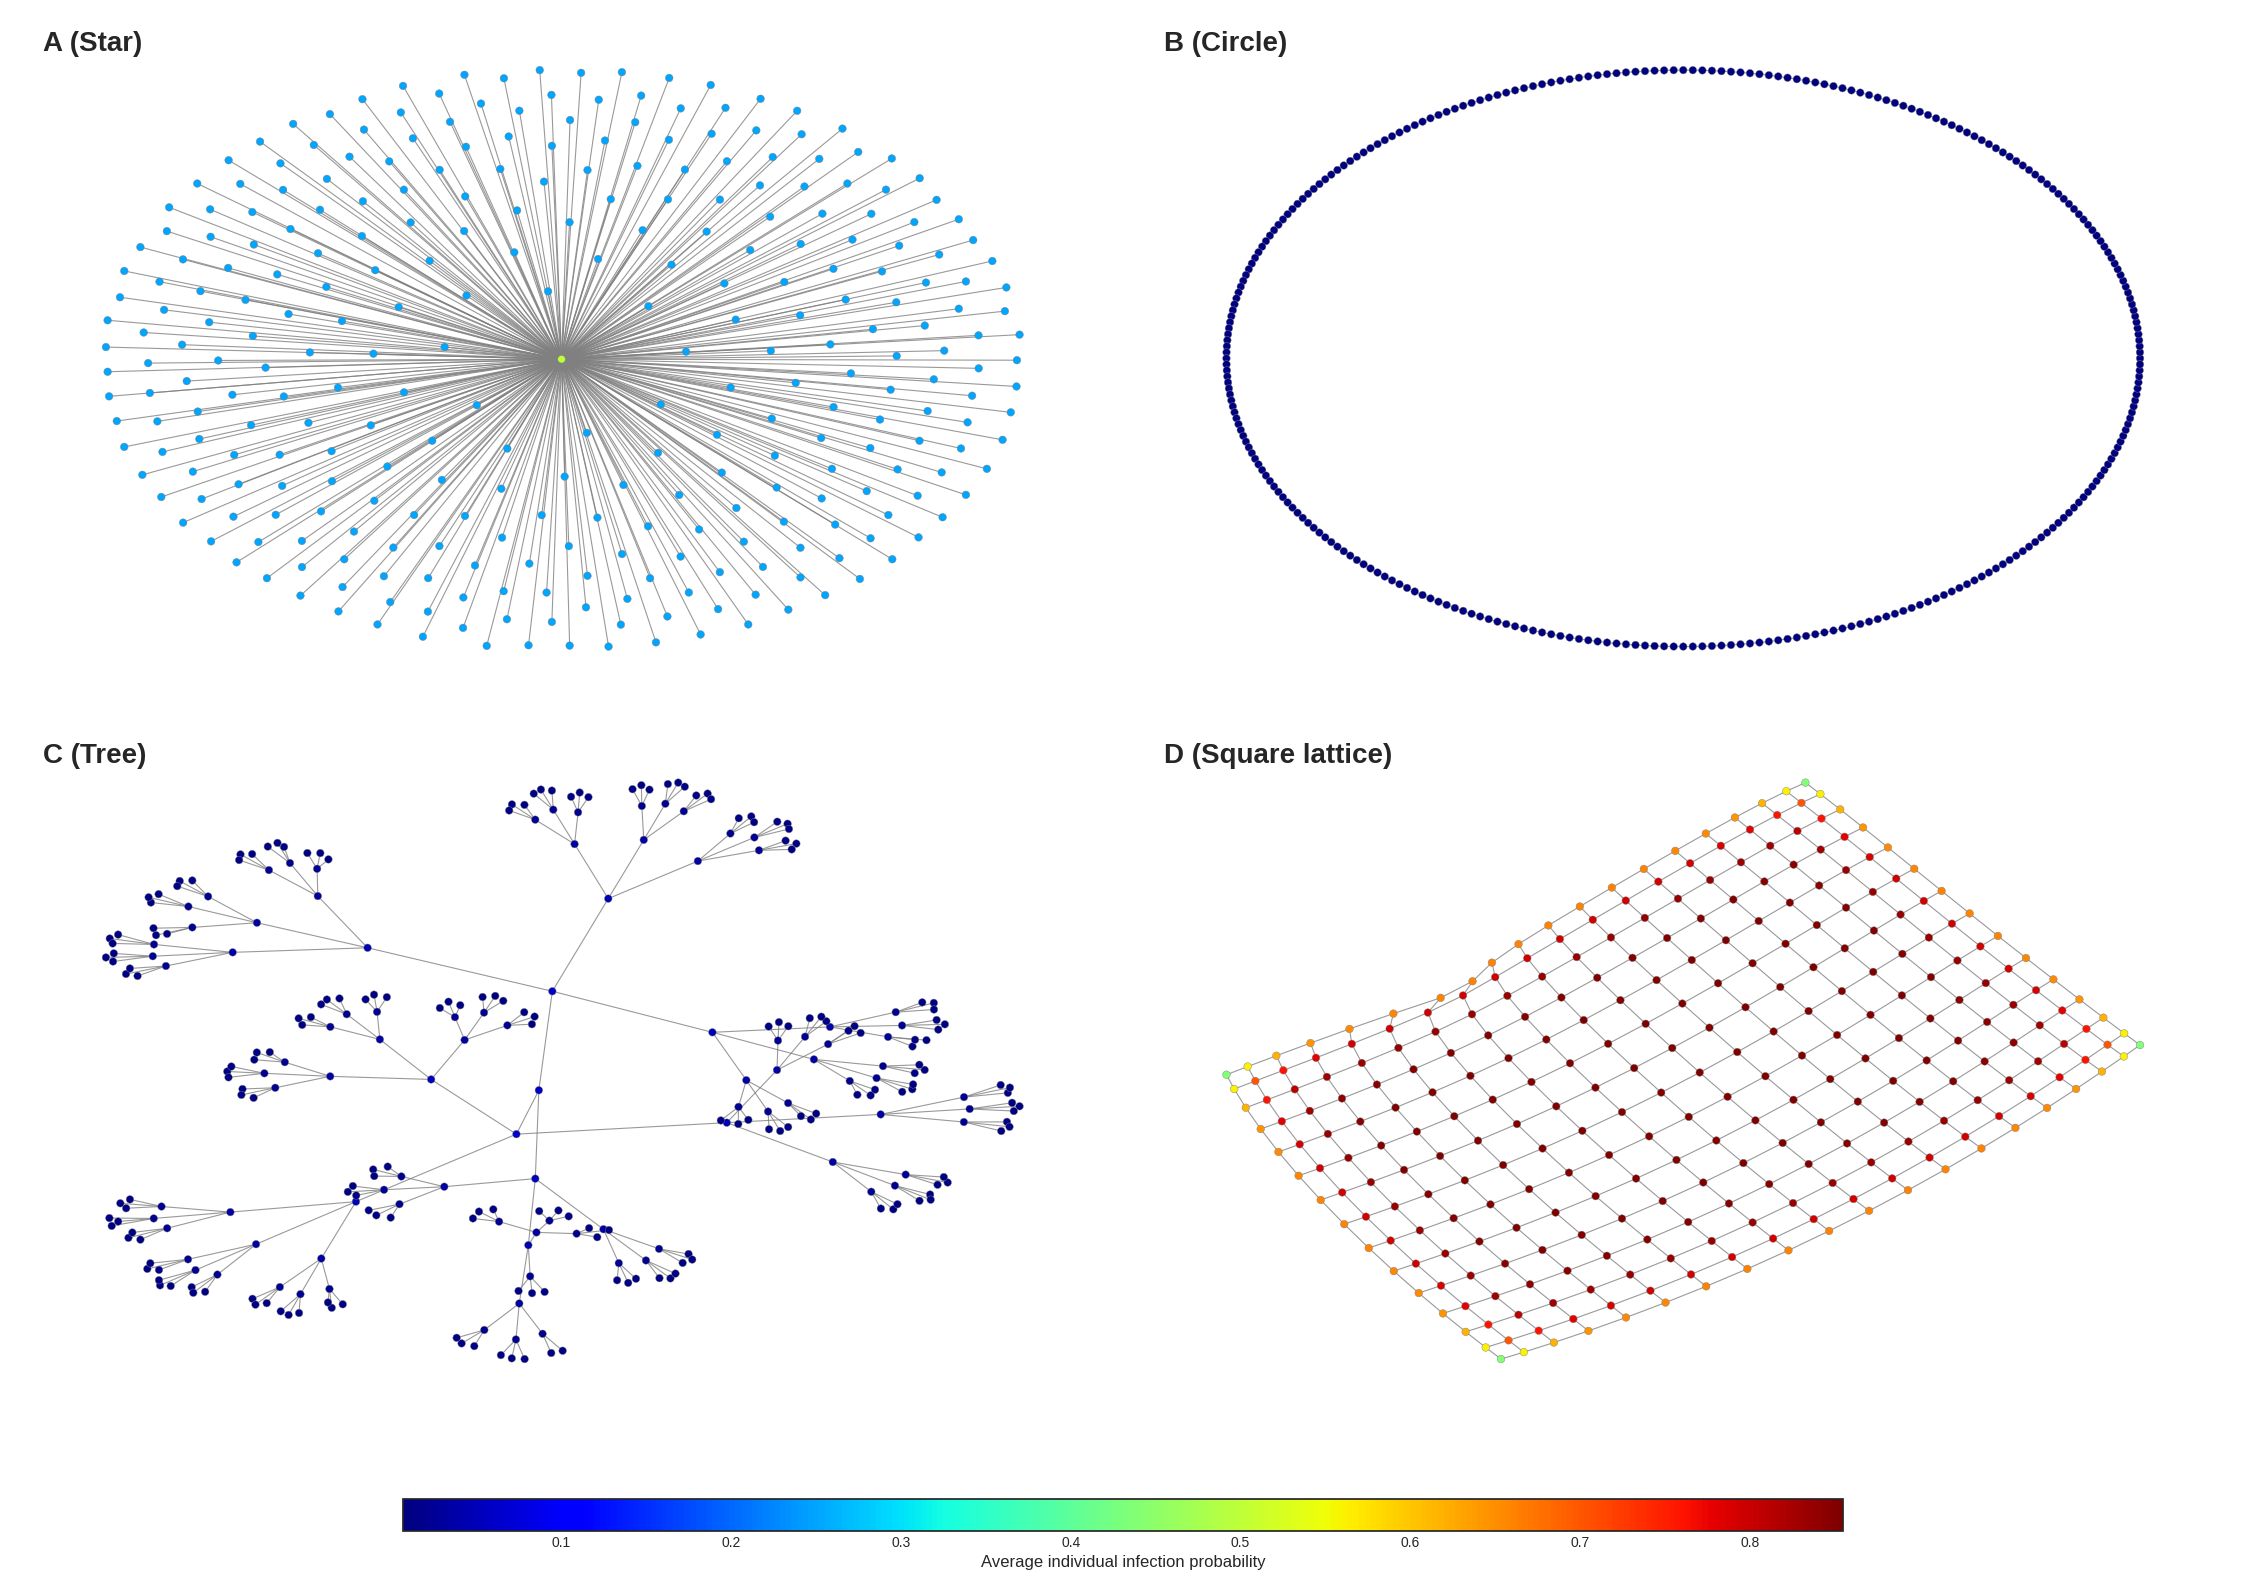

In [ ]:
visualize_attack_network_comparison(
    G_star,   nodes_star,   avg_attack_star,
    G_circle, nodes_circle, avg_attack_circle,
    G_tree,   nodes_tree,   avg_attack_tree,
    G_sq,     nodes_sq,     avg_attack_sq,
    cmap_name="jet",
    out_path=os.path.join(outdir, f"network_compare_star_circle_tree_sq.pdf")
)

In [ ]:
plot_ranked_histogram_four_panel(
    ranked_csv_path_star=ranked_star_path,
    ranked_csv_path_circle=ranked_circle_path,
    ranked_csv_path_tree=ranked_tree_path,
    ranked_csv_path_sq=ranked_sq_path,
    outdir=outdir,
    fig_name=f"hist_ranked_attack_star_circle_tree_sq.pdf"
)

make_centrality_figure(
    neighbors_path_star=neighbors_star_path,
    ranked_path_star=ranked_star_path,
    neighbors_path_circle=neighbors_circle_path,
    ranked_path_circle=ranked_circle_path,
    neighbors_path_tree=neighbors_tree_path,
    ranked_path_tree=ranked_tree_path,
    neighbors_path_sq=neighbors_sq_path,
    ranked_path_sq=ranked_sq_path,
    outdir=outdir,
    merged_basename_star=f"ranked_with_centrality_star.csv",
    merged_basename_circle=f"ranked_with_centrality_circle.csv",
    merged_basename_tree=f"ranked_with_centrality_tree.csv",
    merged_basename_sq=f"ranked_with_centrality_sq.csv",
    fig_basename=f"centrality_star_circle_tree_sq.pdf"
)

In [ ]:
# Histogram for distribution of probability for a node of a certain degree
def plot_prob_histograms_by_degree(individual_csv,
                                   neighbors_csv,
                                   bins=np.linspace(0, 1, 21),
                                   max_cols=6,
                                   save_pdf=True,
                                   outname="histograms_by_degree.pdf"):

    df_indiv = pd.read_csv(individual_csv)
    df_deg   = pd.read_csv(neighbors_csv)

    prob_cols = [c for c in df_indiv.columns if c.startswith("Seed ")]
    probs = df_indiv[prob_cols].to_numpy()

    np.fill_diagonal(probs, np.nan)

    N = probs.shape[0]
    deg_series = df_deg.set_index("node")["degree"].reindex(np.arange(N))

    unique_degrees = np.sort(deg_series.unique())
    n_deg = len(unique_degrees)

    n_cols = min(max_cols, n_deg)
    n_rows = math.ceil(n_deg / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 3.2 * n_rows),
                             sharex=True, sharey=True)

    if n_deg == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, k in enumerate(unique_degrees):
        ax = axes[idx]
        nodes_k = np.where(deg_series.values == k)[0]
        data_k = probs[nodes_k, :].ravel() # get all the probabilities for these rows
        data_k = data_k[~np.isnan(data_k)]

        if len(data_k) > 0:
            weights = np.ones_like(data_k) * 100.0 / len(data_k)
            ax.hist(data_k, bins=bins, weights=weights, edgecolor="black")

        ax.set_title(f"Degree k={k} (n={len(nodes_k)})")

        row = idx // n_cols
        col = idx % n_cols

        if row == n_rows - 1:
            ax.set_xlabel("Probability")
        else:
            ax.set_xlabel("")

        if col == 0:
            ax.set_ylabel("Frequency (%)")
        else:
            ax.set_ylabel("")

    for j in range(n_deg, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_pdf:
        outdir = os.path.dirname(individual_csv)
        outfile = os.path.join(outdir, outname)
        plt.savefig(outfile, format="pdf", dpi=300, bbox_inches="tight")
        print("Saved PDF to:", outfile)

    #plt.show()

In [ ]:
base_dir = "/content/drive/My Drive/Individual_Attack_Rate"

individual_csv_star   = f"{base_dir}/individual_attack_star.csv"
neighbors_csv_star    = f"{base_dir}/graph_neighbors_star.csv"

individual_csv_circle = f"{base_dir}/individual_attack_circle.csv"
neighbors_csv_circle  = f"{base_dir}/graph_neighbors_circle.csv"

individual_csv_tree   = f"{base_dir}/individual_attack_tree.csv"
neighbors_csv_tree    = f"{base_dir}/graph_neighbors_tree.csv"

individual_csv_sq     = f"{base_dir}/individual_attack_sq.csv"
neighbors_csv_sq      = f"{base_dir}/graph_neighbors_sq.csv"

cases = [
    (individual_csv_star,   neighbors_csv_star,   "degree_hist_panels_star.pdf"),
    (individual_csv_circle, neighbors_csv_circle, "degree_hist_panels_circle.pdf"),
    (individual_csv_tree,   neighbors_csv_tree,   "degree_hist_panels_tree.pdf"),
    (individual_csv_sq,     neighbors_csv_sq,     "degree_hist_panels_square_lattice.pdf"),
]

for indiv_csv, neigh_csv, outname in cases:
    plot_prob_histograms_by_degree(
        indiv_csv,
        neigh_csv,
        outname=outname
    )
